# Building an AI-powered multimodal RAG system with Docling and Granite

*Using IBM Granite vision, text-based embeddings and generative AI models*

## Multimodal retrieval-augmented generation

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Multimodal RAG can use [multimodal](https://www.ibm.com/think/topics/multimodal-ai) LLMs (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms. Popular multimodal LLMs include Google’s Gemini, Meta’s Llama 3.2 and OpenAI’s GPT-4 and GPT-4o.

For this recipe, you will use an IBM Granite model capable of processing different modalities. You will create an AI system to answer real-time user queries from unstructured data in a PDF.

## Recipe overview

Welcome to this Granite recipe. In this recipe, you'll learn how to harness the power of advanced tools to build an AI-powered multimodal RAG pipeline. This tutorial will guide you through the following processes:

- **Document preprocessing:** Learn how to handle documents from various sources, parse and transform them into usable formats and store them in vector databases by using Docling. You will use a Granite MLLM to generate image descriptions of images in the documents.
- **RAG:** Understand how to connect LLMs such as Granite with external knowledge bases to enhance query responses and generate valuable insights.
- **LangChain for workflow integration:** Discover how to use LangChain to streamline and orchestrate document processing and retrieval workflows, enabling seamless interaction between different components of the system.

This recipe uses three cutting-edge technologies:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[Granite](https://www.ibm.com/granite/docs/models/granite/):** A state-of-the-art LLM that provides robust natural language capabilities and a vision language model that provides image to text generation.
3. **[LangChain](https://github.com/langchain-ai/langchain):** A powerful framework used to build applications powered by language models, designed to simplify complex workflows and integrate external tools seamlessly.

By the end of this recipe, you will accomplish the following:
- Gain proficiency in document preprocessing, chunking and image understanding.
- Integrate vector databases to enhance retrieval capabilities.
- Use RAG to perform efficient and accurate data retrieval for real-world applications.

This recipe is designed for AI developers, researchers and enthusiasts looking to enhance their knowledge of document management and advanced natural language processing (NLP) techniques.


## Prerequisites

- Familiarity with Python programming.
- Basic understanding of LLMs, NLP concepts and computer vision.

## Step 1: Setting up the environment

Install dependencies.

In [11]:
! echo "::group::Install Dependencies"
%pip install uv
! uv pip install git+https://github.com/ibm-granite-community/utils.git \
    transformers \
    pillow \
    langchain_classic \
    langchain_core \
    langchain_huggingface sentence_transformers \
    langchain_milvus 'pymilvus[milvus_lite]' \
    docling \
    'langchain_replicate @ git+https://github.com/ibm-granite-community/langchain-replicate.git'
! echo "::endgroup::"

::group::Install Dependencies
Using Python 3.12.12 environment at: /usr
Resolved 124 packages in 1.95s
Audited 124 packages in 5ms
::endgroup::


## Step 2: Selecting the AI models

### Logging

To see some logging information, we can configure INFO log level.

NOTE: It is okay to skip running this cell.

In [12]:
import logging

logging.basicConfig(level=logging.INFO)

### Load the Granite models

Specify the embeddings model to use for generating text embedding vectors. Here we will use one of the [Granite Embeddings models](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb)

To use a different embeddings model, replace this code cell with one from [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

In [13]:
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer

embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_model = HuggingFaceEmbeddings(
    model_name=embeddings_model_path,
)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)

Specify the MLLM to use for image understanding. We will use the Granite vision model.

In [14]:
from ibm_granite_community.notebook_utils import get_env_var
from langchain_replicate import Replicate
from transformers import AutoProcessor

vision_model_path = "ibm-granite/granite-vision-3.3-2b"
vision_model = Replicate(
    model=vision_model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": embeddings_tokenizer.max_len_single_sentence, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)
vision_processor = AutoProcessor.from_pretrained(vision_model_path)

Specify the language model to use for the RAG generation operation. Here we use the Replicate LangChain client to connect to a Granite model from the [`ibm-granite`](https://replicate.com/ibm-granite) org on Replicate.

To get set up with Replicate, see [Getting Started with Replicate](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_Replicate.ipynb).

To connect to a model on a provider other than Replicate, substitute this code cell with one from the [LLM component recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_LLMs.ipynb).

In [5]:
from langchain_replicate import ChatReplicate

model_path = "ibm-granite/granite-4.0-h-small"
model = ChatReplicate(
    model=model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": 1000, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)

## Step 3: Preparing the documents for the vector database

In this example, from a set of source documents, we use [Docling](https://docling-project.github.io/docling/) to convert the documents into text and images. The text is then split into chunks. The images are processed by the MLLM to generate image summaries.

### Use Docling to download the documents and convert to text and images

Docling will download the PDF documents and process them so we can obtain the text and images the documents contain. In the PDF, there are various data types, including text, tables, graphs and images.

In [15]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions

pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True,
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}
converter = DocumentConverter(format_options=format_options)

sources = [
    "https://midwestfoodbank.org/images/AR_2020_WEB2.pdf",
]
conversions = { source: converter.convert(source=source).document for source in sources }

With the documents processed, we then further process the text elements in the documents. We chunk them into appropriate sizes for the embeddings model we are using. A list of LangChain documents are created from the text chunks.

In [16]:
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

doc_id = 0
texts: list[Document] = []
for source, docling_document in conversions.items():
    for chunk in HybridChunker(tokenizer=embeddings_tokenizer).chunk(docling_document):
        items = chunk.meta.doc_items
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue # we will process tables later
        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        print(refs)
        text = chunk.text
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,
            },
        )
        texts.append(document)

print(f"{len(texts)} text document chunks created")

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


#/texts/1
#/texts/4 #/texts/5 #/texts/6 #/texts/7 #/texts/8 #/texts/9 #/texts/10 #/texts/11 #/texts/12 #/texts/13
#/tables/0 #/texts/16 #/texts/17 #/texts/18
#/texts/21
#/texts/23
#/texts/25
#/texts/27
#/texts/29
#/texts/31
#/texts/33
#/texts/35 #/texts/38 #/texts/39 #/texts/40 #/texts/41
#/texts/45 #/texts/46
#/texts/48 #/texts/49 #/texts/50 #/texts/51 #/texts/52 #/texts/53 #/texts/54 #/texts/55 #/texts/56 #/texts/57
#/texts/59 #/texts/60 #/texts/61 #/texts/62 #/texts/63 #/texts/64 #/texts/65
#/texts/141
#/tables/1 #/texts/145 #/texts/153
#/texts/157 #/texts/158
#/texts/160 #/texts/161 #/texts/162
#/texts/166 #/texts/167 #/texts/168 #/texts/169
#/texts/182
#/texts/184 #/texts/185 #/texts/186 #/texts/187 #/texts/188 #/texts/189 #/texts/190
#/texts/193
#/texts/195
#/texts/197
#/texts/199
#/texts/201
#/texts/203
#/texts/205
#/texts/207
#/texts/209
#/texts/211
#/texts/213
#/texts/215
#/texts/217
#/texts/225 #/texts/226 #/texts/227
#/texts/229 #/texts/230
#/texts/232
#/texts/235 #/texts/23

Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [17]:
from docling_core.types.doc.labels import DocItemLabel

doc_id = len(texts)
tables: list[Document] = []
for source, docling_document in conversions.items():
    for table in docling_document.tables:
        if table.label in [DocItemLabel.TABLE]:
            ref = table.get_ref().cref
            print(ref)
            text = table.export_to_markdown(docling_document)
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref
                },
            )
            tables.append(document)


print(f"{len(tables)} table documents created")

#/tables/1
1 table documents created


Finally we process any images in the documents. Here we use the vision language model to understand the content of an image. In this example, we are interested in any textual information in the image. You might want to experiment with different prompt text to see how it might improve the results.

NOTE: Processing the images can take a very long time depending upon the number of images and the service running the vision language model.

In [19]:
import time
import base64
import io
import PIL.Image
import PIL.ImageOps
from ibm_granite_community.langchain.prompts import TokenizerChatPromptTemplate
from langchain_core.messages import HumanMessage
from replicate.exceptions import ReplicateError


def encode_image(image: PIL.Image.Image, format: str = "png") -> str:
    image = PIL.ImageOps.exif_transpose(image) or image
    image = image.convert("RGB")

    buffer = io.BytesIO()
    image.save(buffer, format)
    encoding = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return f"data:image/{format};base64,{encoding}"


# Prompt template setup
image_prompt = "If the image contains text, explain the text in the image."
vision_prompt_template = TokenizerChatPromptTemplate.from_messages(
    messages=[
        HumanMessage(content=[
            {"type": "image"},
            {"type": "text", "text": image_prompt},
        ]),
    ],
    tokenizer=vision_processor,
)
vision_prompt = vision_prompt_template.format_prompt()


pictures = []
doc_id = len(texts) + len(tables)

MAX_IMAGES = 5  # prevent too many API calls
processed_count = 0


def safe_invoke_vision(image_data):
    """Retry vision_model.invoke() safely with backoff."""
    while True:
        try:
            return vision_model.invoke(vision_prompt, images=[image_data])
        except ReplicateError as e:
            if "rate limit" in str(e).lower() or "throttled" in str(e).lower():
                print("Rate limit hit. Waiting 10 seconds...")
                time.sleep(10)
            else:
                raise e


for source, docling_document in conversions.items():

    for picture in docling_document.pictures:
        if processed_count >= MAX_IMAGES:
            print("Reached MAX_IMAGES limit — stopping early.")
            break

        ref = picture.get_ref().cref
        print(ref)

        img = picture.get_image(docling_document)
        if img:
            encoded = encode_image(img)

            # SAFE API CALL
            text = safe_invoke_vision(encoded)

            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id := doc_id + 1),
                    "source": source,
                    "ref": ref,
                },
            )
            pictures.append(document)
            processed_count += 1

            time.sleep(2)  # small delay to avoid rate spikes

print(f"{len(pictures)} image descriptions created")


#/pictures/0
#/pictures/1
Rate limit hit. Waiting 10 seconds...
#/pictures/2
Rate limit hit. Waiting 10 seconds...
#/pictures/3
Rate limit hit. Waiting 10 seconds...
#/pictures/4
Rate limit hit. Waiting 10 seconds...
Reached MAX_IMAGES limit — stopping early.
5 image descriptions created


We can then display the LangChain documents created from the input documents.

Document ID: 1
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
bridging the gap between poverty and prosperity
Document ID: 2
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year. With the help of volunteers, donors, staff, and most importantly, the blessings of God, Midwest Food Bank responded nimbly to the changing landscape.
All  MFB  locations  remained  open  and  responsive  to  the  need  of  our nonprofit partners. We enacted safety protocols and reduced volunteer numbers  to  maintain  social  distancing  guidelines.  To  allow  partner agencies to receive food from MFB safely, we altered our distribution model.  Community,  business,  and  donor  support  funded  operations and helped with food purchases. More details on our response to the pandemic are on page 14.
Noteworthy in 2020:
- MFB distributed a record amount of food, 37% more than 

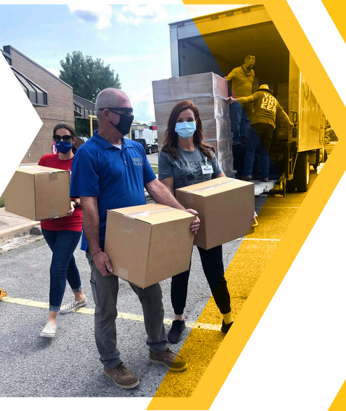

Document ID: 75
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "Midwest Food Bank." This is the name of the organization, which is likely a non-profit entity that provides food assistance to those in need. The text is clear and legible, with no additional text present that could alter its meaning. The logo above the text is emblematic of the organization's focus on food and agriculture, which is a common theme for food banks. The design of the logo, with its simple and bold typography, is intended to be easily recognizable and to convey the organization's mission and purpose.
Image:


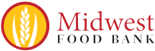

Document ID: 76
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image, "KEEP MOVING FORWARD," is a motivational phrase. It is commonly used to encourage perseverance and progress, especially in the face of challenges or setbacks. The message is positive and forward-thinking, implying that one should not give up but instead continue to strive and move ahead. This kind of text is often found in contexts where personal development, self-improvement, or business success is being promoted. It serves as a reminder that progress is a journey and that setbacks are temporary.
Image:


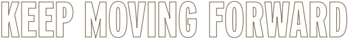

Document ID: 77
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not clearly legible due to the resolution and size of the text. It appears to be a name or title, which is common in professional headshots used for business or personal branding. Since the text is not the main focus of the image and is partially obscured, it is not possible to accurately describe or transcribe it. If the text is meant to convey specific information, it would be best to either enlarge the image or use a higher-resolution source to provide a clearer view.
Image:


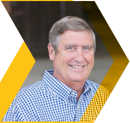

Document ID: 78
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not clearly legible due to the image resolution and the yellow hexagon shape that partially covers it. The text appears to be white or light-colored, which contrasts with the yellow background, making it stand out. However, without a clearer image or additional context, it is not possible to accurately describe or transcribe the text from the image. If you have access to a higher-resolution image, I would recommend it for better analysis. Otherwise, any attempt to transcribe text from this image would be speculative and not professional.
Image:


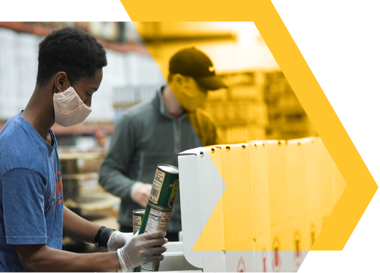

In [20]:
import itertools
from docling_core.types.doc.document import RefItem
from IPython.display import display

# Print all created documents
for document in itertools.chain(texts, tables):
    print(f"Document ID: {document.metadata['doc_id']}")
    print(f"Source: {document.metadata['source']}")
    print(f"Content:\n{document.page_content}")
    print("=" * 80)  # Separator for clarity

for document in pictures:
    print(f"Document ID: {document.metadata['doc_id']}")
    source = document.metadata['source']
    print(f"Source: {source}")
    print(f"Content:\n{document.page_content}")
    docling_document = conversions[source]
    ref = document.metadata['ref']
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    print("Image:")
    display(image)
    print("=" * 80)  # Separator for clarity


## Populate the vector database

Using the embedding model, we load the documents from the text chunks and generated image captioning into a vector database. Creating this vector database allows us to easily conduct a semantic similarity search across our documents.

NOTE: Population of the vector database can take some time depending on your embedding model and service.

### Choose your vector database

Specify the database to use for storing and retrieving embedding vectors.

To connect to a vector database other than Milvus, replace this code cell with one from [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

In [21]:
import tempfile
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus

db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"The vector database will be saved to {db_file}")

vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"},
)

The vector database will be saved to /tmp/vectorstore_ouddpai6.db


We now add all the LangChain documents for the text, tables and image descriptions to the vector database.

In [22]:
import itertools

documents = list(itertools.chain(texts, tables, pictures))
ids = vector_db.add_documents(documents)
print(f"{len(ids)} documents added to the vector database")

78 documents added to the vector database


## Step 4: RAG with Granite

Now that we have successfully converted our documents and vectorized them, we can set up out RAG pipeline.

### Retrieve relevant chunks



Here we test the vector database by searching for chunks with relevant information to our query in the vector space. We display the documents associated with the retrieved image description.

Feel free to try different queries.

In [23]:
query = "How much was spent on food distribution relative to the amount of food distributed?"
for doc in vector_db.as_retriever().invoke(query):
    print(doc)
    print("=" * 80)  # Separator for clarity

page_content='Midwest Food Bank Growth Value of food distributed (millions) Value of food distributed (millions)' metadata={'pk': 462831940144988174, 'doc_id': 15, 'source': 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf', 'ref': '#/texts/141'}
page_content='We  receive  donated  food  from  all  over  the country  -  food  produced  in  excess,  incorrect labeling,  and  more.  Donated  food  comes  from various sources:
- Food manufacturers
- Food distribution centers
- USDA programs
- Grocery stores
- Private food drives' metadata={'pk': 462831940144988202, 'doc_id': 43, 'source': 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf', 'ref': '#/texts/271 #/texts/272 #/texts/273 #/texts/274 #/texts/275 #/texts/276'}
page_content='Provide industry-leading food relief to those in need while feeding them spiritually.
NOUN
the state of being without reliable access to a sufficient quantity of affordable, nutritious food
Food-insecure households have difficulty at some time during t

The returned document should be responsive to the query. Let's go ahead and construct our RAG pipeline.

### Create the RAG pipeline for Granite

First we create the prompts for Granite to perform the RAG query. We use the Granite chat template and supply the placeholder values that the LangChain RAG pipeline will replace.

Next, we construct the RAG pipeline by using the Granite prompt templates previously created.


In [24]:
from ibm_granite_community.langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_classic.chains.retrieval import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate

# Create a Granite prompt for question-answering with the retrieved context
prompt_template = ChatPromptTemplate.from_template("{input}")

# Assemble the retrieval-augmented generation chain
combine_docs_chain = create_stuff_documents_chain(
    llm=model,
    prompt=prompt_template,
)
rag_chain = create_retrieval_chain(
    retriever=vector_db.as_retriever(),
    combine_docs_chain=combine_docs_chain,
)

### Generate a retrieval-augmented response to a question

The pipeline uses the query to locate documents from the vector database and use them as context for the query.

In [25]:
from ibm_granite_community.notebook_utils import wrap_text

output = rag_chain.invoke({"input": query})

print(wrap_text(output['answer']))

Based on the provided context, it is not possible to determine the exact amount
spent on food distribution relative to the amount of food distributed. The
information given does not include any specific financial data or metrics on the
costs associated with the food distribution efforts. The context focuses on the
sources of donated food, the prevalence of food insecurity, and the impact of
the organization's work, but does not provide any quantitative details on the
financial aspects of the food distribution operations. Without additional
information on the organization's budget, expenses, or the value of the food
distributed, the question cannot be answered from the available context.


Awesome! We have created an AI application that can successfully leverage knowledge from the source documents' text and images.

## Next Steps

- Explore advanced RAG workflows for other industries.
- Experiment with other document types and larger datasets.
- Optimize prompt engineering for better Granite responses.

Thank you for using this recipe!